In [1]:
!pip install openai

Enter the YouTube video URL: https://youtu.be/OKJImnk-gzQ?feature=shared


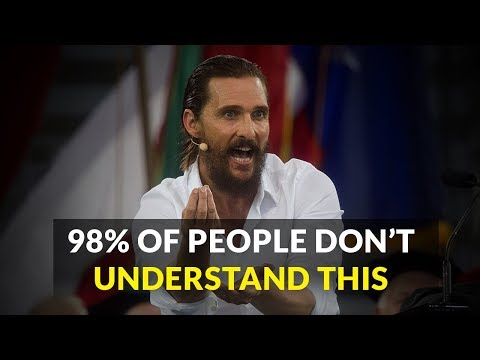

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Summary saved and downloaded as 'summarized_text.txt'.


In [2]:
import requests
import json
import os
import math
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import YouTubeVideo
from urllib.parse import urlparse, parse_qs
from google.colab import files  # Import for downloading files in Colab

# Replace with your Groq API key
GROQ_API_KEY = "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"

# Function to extract YouTube video ID from URL
def get_video_id(url):
    parsed_url = urlparse(url)
    if parsed_url.hostname in ["www.youtube.com", "youtube.com"]:
        return parse_qs(parsed_url.query).get("v", [None])[0]
    elif parsed_url.hostname == "youtu.be":
        return parsed_url.path.lstrip("/")
    return None

# Function to summarize text using Groq API
def summarize_with_groq(text):
    url = "https://api.groq.com/openai/v1/chat/completions"  # Corrected endpoint
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "mixtral-8x7b-32768",
        "messages": [{"role": "system", "content": "Summarize the following text concisely:"},
                     {"role": "user", "content": text}],
        "temperature": 0.3,
        "max_tokens": 300
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print("Error with Groq API:", response.json())
        return None

# Ask the user to enter a YouTube URL
youtube_video = input("Enter the YouTube video URL: ").strip()
video_id = get_video_id(youtube_video)

if video_id:
    display(YouTubeVideo(video_id))

    try:
        # Get transcript
        transcript = YouTubeTranscriptApi.get_transcript(video_id)

        if not transcript:
            print("No transcript available for this video.")
        else:
            # Convert transcript to a single text string
            result = " ".join([i['text'] for i in transcript])

            # Define chunk size and split text accordingly
            chunk_size = 4096  # Mixtral can handle large inputs
            num_iters = math.ceil(len(result) / chunk_size)

            summarized_text = []

            # Process transcript in chunks
            for i in range(num_iters):
                start = i * chunk_size
                end = min((i + 1) * chunk_size, len(result))
                chunk = result[start:end]

                if len(chunk) < 50:  # Skip very small chunks
                    continue

                # Summarize text chunk using Groq API
                summary = summarize_with_groq(chunk)
                if summary:
                    summarized_text.append(summary)

            # Combine all summarized sections
            final_summary = " ".join(summarized_text)

            # Format text (10 words per line)
            words = final_summary.split()
            formatted_text = "\n".join([" ".join(words[i:i+10]) for i in range(0, len(words), 10)])

            # Save to a text file
            file_path = "summarized_text.txt"
            with open(file_path, "w", encoding="utf-8") as file:
                file.write(formatted_text)

            # Automatically download the file
            files.download(file_path)

            print("\nSummary saved and downloaded as 'summarized_text.txt'.")

    except Exception as e:
        print("Error retrieving transcript:", e)
else:
    print("Invalid YouTube URL")
